In [31]:
import torch
from model import UNet
from dataset import RetinaDataset
from utils import load_data
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import segmentation_models_pytorch as smp
import warnings

warnings.filterwarnings("ignore")

EXP_ID = 18808

MODEL_PATH = f"/scratch/y.aboelwafa/Retina/Retina_Blood_Vessel_Segmentation/checkpoints/pytorch_{EXP_ID}.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(3, 1)
model.to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device("cpu")))

<All keys matched successfully>

In [2]:
show_imgs = 1
test_transform = A.Compose(
    [
        A.Resize(512, 512),
    ]
)
train_images, train_masks, test_images, test_masks = load_data("dataset")
test_dataset = RetinaDataset(test_images, test_masks, transform=test_transform)

In [21]:
def connected_components(img, min_threshold=0.3, max_threshold=0.5):

    _, sure_edges = cv2.threshold(img, max_threshold, 1, cv2.THRESH_BINARY)

    _, eliminated_edges = cv2.threshold(img, min_threshold, 1, cv2.THRESH_BINARY_INV)

    uncertain_edges = np.logical_and(img > min_threshold, img < max_threshold).astype(
        np.uint8
    )

    num_sure, sure_labels = cv2.connectedComponents(
        sure_edges.astype(np.uint8), connectivity=8
    )

    num_uncertain, uncertain_labels = cv2.connectedComponents(
        uncertain_edges, connectivity=8
    )
    
    combined = sure_labels.copy()
    
    for label in range(1, num_uncertain):
        uncertain_mask = (uncertain_labels == label)
        sure_neighbors = sure_labels[uncertain_mask]
        sure_neighbors = sure_neighbors[sure_neighbors > 0]
        
    
    combined[combined > 0] = 1
    
    return num_sure, sure_labels, num_uncertain, uncertain_labels, combined

Number of sure components =  26
Number of uncertain components =  1981
IoU Score before hysteresis thresholding =  0.6753510236740112


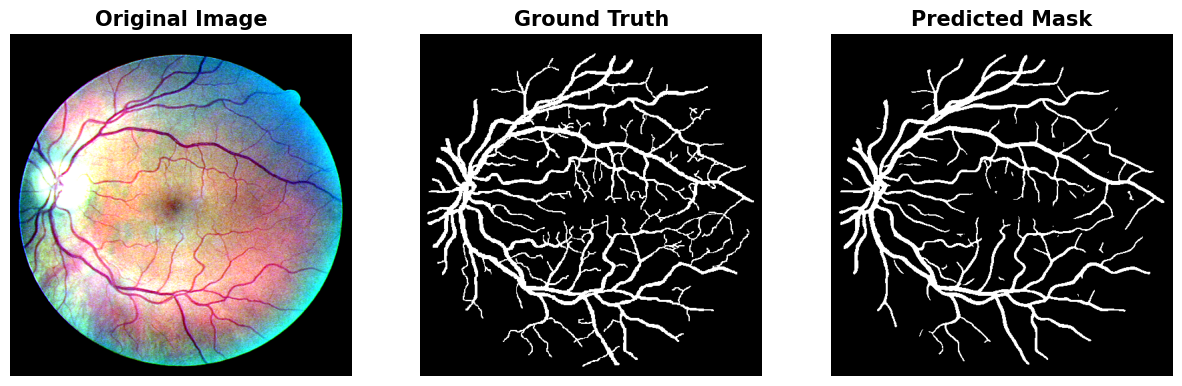

IoU Score after hysteresis thresholding =  0.6857800483703613


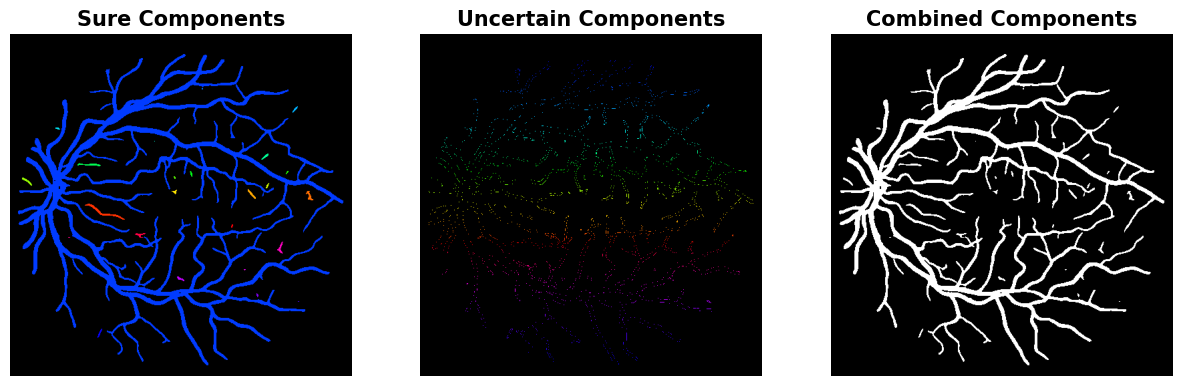

In [30]:
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)
for i in range(show_imgs):
    img, mask = test_dataset[random_list[i]]
    img = img.unsqueeze(0).to(device)
    mask = mask.unsqueeze(0).to(device)
    pred = model(img)
    pred = torch.sigmoid(pred)
    mask = mask.round().long()
    
    tp, fp, fn, tn = smp.metrics.get_stats(pred, mask, mode="binary", threshold=0.5) # type: ignore
    iou_before = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()

    img = img.squeeze().permute(1, 2, 0).numpy()
    mask = mask.squeeze().numpy()
    pred = pred.squeeze().detach().numpy()
    
    num_sure, sure_labels, num_uncertain, uncertain_labels, combined = connected_components(pred, 0.1, 0.2)
    
    print("Number of sure components = ", num_sure)
    print("Number of uncertain components = ", num_uncertain)
    
    print("IoU Score before hysteresis thresholding = ", iou_before)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    pred = pred > 0.5

    ax[0].imshow(img)
    ax[0].set_title("Original Image", fontsize=15, weight="bold")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Ground Truth", fontsize=15, weight="bold")
    ax[1].axis("off")

    ax[2].imshow(pred, cmap="gray")
    ax[2].set_title("Predicted Mask", fontsize=15, weight="bold")
    ax[2].axis("off")

    plt.show()

    mask = torch.tensor(mask).unsqueeze(0).unsqueeze(0).to(device)
    combined_tensor = torch.tensor(combined).unsqueeze(0).unsqueeze(0).float().to(device)
    tp, fp, fn, tn = smp.metrics.get_stats(combined_tensor, mask, mode="binary", threshold=0.5) # type: ignore
    iou_after = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
    print("IoU Score after hysteresis thresholding = ", iou_after)
    
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    label_hue = np.uint8(179 * sure_labels / np.max(sure_labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])  # type: ignore
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0

    ax[0].imshow(labeled_img)
    ax[0].set_title("Sure Components", fontsize=15, weight="bold")
    ax[0].axis("off")
    
    label_hue = np.uint8(179 * uncertain_labels / np.max(uncertain_labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])  # type: ignore
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0
    
    ax[1].imshow(labeled_img)
    ax[1].set_title("Uncertain Components", fontsize=15, weight="bold")
    ax[1].axis("off")
    
    ax[2].imshow(combined, cmap="gray")
    ax[2].set_title("Combined Components", fontsize=15, weight="bold")
    ax[2].axis("off")

    plt.show()